# Dual-tone multi-frequency (DTMF) signaling

DTMF signaling is the way analog phones send the number dialed by a user over to the central phone office. This was in the day before all-digital networks and cell phones were the norm, but the method is still used for in-call option selection ("press 4 to talk to customer service"...).

The mechanism is rather clever: the phone's keypad is arranged in a $4\times 3$ grid and each button is associated to *two* frequencies according to this table:


|            | **1209 Hz** | **1336 Hz** | **1477 Hz** |
|------------|:-----------:|:-----------:|:-----------:|
| **697 Hz** |      1      |      2      |      3      |
| **770 Hz** |      4      |      5      |      6      |
| **852 Hz** |      7      |      8      |      9      |
| **941 Hz** |      *      |      0      |      #      |


The  frequencies in the table have been chosen so that they are "coprime"; in other words, no frequency is a multiple of any other, which reduces the probability of erroneously detecting the received signals due to interference. When a button is pressed, the two corresponding frequencies are generated simultaneously and sent over the line. For instance, if the digit '1' is pressed, the generated signal will be:

$$
    x(t) = \sin(2\pi\cdot 1209\cdot t) + \sin(2\pi\cdot697\cdot t)
$$


The official specifications for the DTMF standard further stipulate that:

 * each tone should be at least 65ms long
 * tones corresponding to successive digits should be separated by a silent gap of at least 65ms


In this notebook we will build a DTMF decoder based on the Discrete Fourier Transform. 
Of course here we will use discrete-time signals exclusively so, if the clock of the system is $F_s$, each DTMF tone will be of the form:
$$
    x[n] = \sin(2\pi\,(f_l/F_s)\, n) + \sin(2\pi\,(f_h/F_s)\,n)
$$

The first thing to do is to write a DTMF encoder.

In [110]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
class PhoneClient():
    def __init__(self,Fs=24000):
        '''
        Fs是系统采样率，默认是24K,一秒采集24K个样本点
        '''
        self.key2signal={
            '1':(697,1209),
            '2':(697,1336),
            '3':(697,1477),
            '4':(770,1209),
            '5':(770,1336),
            '6':(770,1477),
            '7':(852,1209),
            '8':(852,1336),
            '9':(852,1477),
            '*':(941,1209),
            '0':(941,1336),
            '#':(941,1477),
        }
        self.Fs=Fs
        self.interval=int(Fs/10) #产生信号的时间0.01s
        self.gap=int(Fs/10) #产生gap的时间0.01s
    def diag(self,number):
        '''
        number:一串数字
        返回:数字对于的信号(1D)
        '''
        ret=[]
        for d in number:
            f1,f2=self.key2signal[d]
            n=np.arange(self.interval)
            signal=np.sin(2*np.pi*f1*n/self.Fs)+np.sin(2*np.pi*f2*n/self.Fs)
            idle_signal=np.zeros(self.gap)
            ret.append(np.concatenate((signal,idle_signal)))
        r=np.concatenate(ret)
        assert len(r)==len(number)*(self.interval+self.gap)
        return r

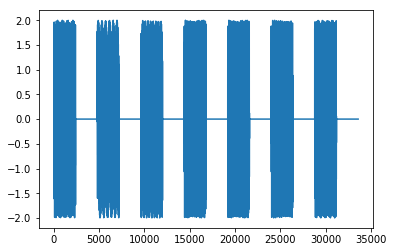

In [112]:
Fs=24000
phone=PhoneClient(Fs)
x=phone.diag('123##45')
plt.plot(x)

### 设计算法，用于分离 拨号信号
    1.设在窗口变量window size,每一个窗口计算一下energy,
    2.取大于 阈值 之间的窗口信号

In [113]:
def window_split(x,windowSize):
    '''
    每windowSize个样本当成一个窗口，计算所有窗口的能量返回
    '''
    x=x[:windowSize*(len(x)//windowSize)]
    energy=[]
    for i in range(0,len(x),windowSize):
        e=(x[i:i+windowSize]**2).sum()
        energy.append(e)
    return np.array(energy)
def dtmf_split(x,windowsize,thread=220):
    '''
    使用window分析的的方法，把 信号x 分割成 不同的片段，
    每个片段认为代表 一个按键 对于 的信号，返回
    
    list of tuple, tuple(start,end)
    '''
    energy=window_split(x,windowsize)
    start=0
    
    mask=energy>thread
    edges=[]
    for i in range(1,len(energy)):
        if(mask[i-1]==0 and mask[i]==1):
            start=i
        if(mask[i-1]==1 and mask[i]==0):
            end=i
            edges.append((start*windowsize,end*windowsize))
    
    return edges

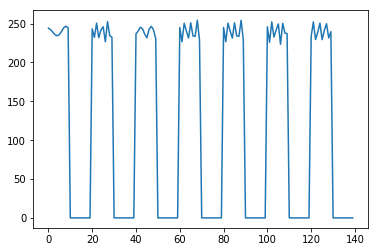

In [115]:
energy=window_split(x,240)
plt.plot(energy)
_=dtmf_split(x,240,100)

###  创建 解析器

In [142]:
class PhoneServer():
    def __init__(self,Fs):
        self.LOWFREQ=np.array([697,770,852,941])
        self.HIGHFREQ=np.array([1209,1336,1477])
        self.KEYS=[['1','2','3'],['4','5','6'],['7','8','9'],['*','0','#']]
        self.Fs=Fs
    def freq2Index(self,freq,N):
        '''
        把 freq转换成索引，换句话说就是一个线性转换
        [0,Fs/2]--->[0,N//2]
        index=f/Fs*N
        返回lisf of index
        '''
        return np.array([np.round(N*f/self.Fs,1) for f in freq]).astype(np.int32)
        
    def lowIndex(self,X):
        fs_index=self.freq2Index(self.LOWFREQ,len(X))
        a,b=fs_index[0],fs_index[-1]
        kmax_in_ab=a+X[a:b].argmax()
        return np.abs(fs_index-kmax_in_ab).argmin()
    def highIndex(self,X):
        fs_index=self.freq2Index(self.HIGHFREQ,len(X))
        a,b=fs_index[0],fs_index[-1]
        kmax_in_ab=a+X[a:b].argmax()
        return np.abs(fs_index-kmax_in_ab).argmin()
    
    def getKey(self,lowindex,highindex):
        return self.KEYS[lowindex][highindex]
    def decode(self,x,windowsize=None,thread=220):
        if windowsize==None:
            windowsize=self.Fs//100
        edges=dtmf_split(x,windowsize,thread)
        ret=[]
        for edge in edges:
            s=x[edge[0]:edge[1]]
            Xs=np.abs(np.fft.fft(s))
            key=self.getKey(self.lowIndex(Xs),self.highIndex(Xs))
            ret.append(key)
        return ret

In [143]:
server=PhoneServer(Fs)
server.decode(x)

['1', '2', '3', '#', '#', '4', '5']